<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/sl_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantifying the performance of machine learning models in materials discovery

In [1]:
# %%time
# !wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
# !chmod +x mini.sh
# !bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
# !python -m ipykernel install --name "py39" --user

In [1]:
!pip install -q numpy pandas scipy pymatgen fdint matminer kaleido ipywidgets notebook lolopy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.1/704.1 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82

In [2]:
!pip install -q pydantic==1.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
confection 0.1.1 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, but you have pydantic 1.8 which is incompatible.
emmet-core 0.67.5 requires pydantic<2.0,>=1.10.2, but you have pydantic 1.8 which is incompatible.
inflect 7.0.0 requires pydantic>=1.9.1, but you have pydantic 1.8 which is incompatible.
spacy 3.6.1 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, but you have pydantic 1.8 which is incompatible.
thinc 8.1.12 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, but you have pydantic 1.8 which is incompatible.


Restart runtime

In [1]:
import os
os.chdir('/content')
if not os.path.exists('sl_discovery'):
  !git clone https://github.com/CitrineInformatics-ERD-public/sl_discovery.git
os.chdir('sl_discovery')

Cloning into 'sl_discovery'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 315 (delta 4), reused 27 (delta 2), pack-reused 274
Receiving objects: 100% (315/315), 670.38 MiB | 15.14 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (234/234), done.


In [2]:
os.chdir('simulated_SL')

In [3]:
%load_ext autoreload
%autoreload 2
import yaml
import time
import sys
import os
import pandas as pd
import numpy as np

# load internal packages and functions
from slworkflow import SLWorkflow, RandomForestRegressorCov
import load_datasets



In [4]:
# load configuration file

basedir = 'configuration_files'
dataset_path = os.path.join('dataset_configs','starrydata_zt_bulk.yaml')
sl_path = os.path.join('sl_configs','1.yaml')

with open(os.path.join(basedir,dataset_path)) as file:
    sl_config = yaml.load(file, Loader=yaml.FullLoader)

with open(os.path.join(basedir,sl_path)) as file:
    sl_config.update(yaml.load(file, Loader=yaml.FullLoader))

print(sl_config)

{'dataset': 'starrydata_zt_bulk', 'output': '8', 'categoricals': None, 'comp_class': '111-type', 'material_family': None, 'filtered': True, 'sample_form': 'Bulk', 'config_id': 1, 'n_sample': 0, 'n_training': 50, 'iterations': 100, 'trials': 100, 'batch': 1, 'discovery_break_number': 0, 'poi': None, 'holdout_fraction': 0.1, 'targets': [[0, 10]]}


In [5]:
if 'starrydata' in sl_config['dataset']:
    df = load_datasets.get_starrydata(out=sl_config['output'],
                        composition_class=sl_config['comp_class'],
                        sample_form=sl_config['sample_form'],
                        material_family=sl_config['material_family'])
    df = df.reset_index()

if 'matbench' in sl_config['dataset']:
    df = load_datasets.get_matbench_dataset(sl_config['dataset'],
                                sl_config['output'])

df.describe()

,index,sampleid,1,paperid,year,2,5,6,4,8,11,12,3,13,14,sigma_E_0,log sigma_E_0,weighted_mobility,quality_factor,log quality_factor
count,329.000000,329.000000,329.0,329.000000,329.000000,313.000000,97.000000,3.160000e+02,304.000000,329.000000,310.000000,15.000000,309.000000,3.200000e+01,0.0,309.000000,309.000000,3.090000e+02,295.000000,292.000000
mean,13439.224924,23797.015198,300.0,15937.537994,1991.039514,0.000006,0.012623,1.666316e-03,5.441104,0.135459,4.928786,0.013710,124627.080036,1.798519e+27,NaN,58617.195920,4.357361,1.938112e-02,0.046217,-1.871766
std,4743.712045,11133.851213,0.0,11073.551048,221.271330,0.000153,0.118488,2.157017e-03,3.550878,0.194548,3.552411,0.014841,155075.287978,2.991732e+27,NaN,69821.542190,0.836628,2.308571e-02,0.086436,0.986523
min,4116.000000,5646.000000,300.0,33.000000,0.000000,-0.000310,0.000001,2.495084e-08,0.000343,0.000002,-0.156699,0.002207,0.856729,5.861576e+24,NaN,2.977438,0.473843,9.844563e-07,-0.310041,-6.060731
25%,8034.000000,11900.000000,300.0,3411.000000,2013.000000,-0.000112,0.000010,2.457946e-04,3.338904,0.022329,2.505962,0.003014,21750.475015,3.786365e+25,NaN,11922.736328,4.076376,3.942119e-03,0.005976,-2.193923
50%,13198.000000,21177.000000,300.0,21244.000000,2017.000000,0.000004,0.000024,1.024893e-03,4.896789,0.068491,4.242399,0.003561,71765.936887,4.034058e+26,NaN,39840.863500,4.600329,1.317293e-02,0.022011,-1.650393
75%,18291.000000,35969.000000,300.0,24802.000000,2020.000000,0.000126,0.000049,2.146097e-03,7.018935,0.149218,6.566368,0.020630,169731.190424,1.950819e+27,NaN,77472.845188,4.889150,2.561553e-02,0.052544,-1.277280
max,20526.000000,41035.000000,300.0,31696.000000,2021.000000,0.000624,1.167230,1.064674e-02,19.031144,0.996731,19.018173,0.053755,985398.117527,1.127236e+28,NaN,361512.693813,5.558124,1.195301e-01,0.601216,-0.220969


In [6]:
df = load_datasets.featurize_composition(df, sl_config['output'])
df = load_datasets.group_and_index_formula(df, sl_config['categoricals'], sl_config['output'])
# df = df.replace([np.inf, -np.inf], np.nan)

if sl_config['categoricals'] != None:
    df = pd.get_dummies(df, columns=sl_config['categoricals'])

StrToComposition:   0%|          | 0/329 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/329 [00:00<?, ?it/s]

/content/sl_discovery/simulated_SL/load_datasets.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('formula', as_index=False).mean().reset_index()


<Axes: >

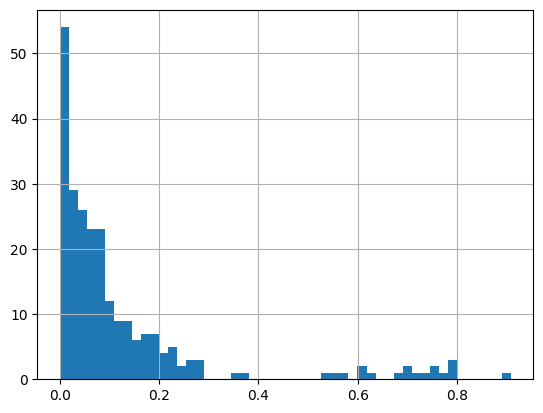

In [7]:
# review output data distribution
df[sl_config['output']].hist(bins=50)

In [8]:
# get categorical / one-hot generated features
encoded_features = []
if sl_config['categoricals'] != None:
    for feature in sl_config['categoricals']:
        encoded_features.extend([x for x in df.keys() if feature in x])

# get all features in one list ('formula' is not a feature but added for plotting convenience)
features = [x for x in df.keys() if 'Magpie' in x]+encoded_features+['formula']

# get features + output
data = df[features+[sl_config['output']]]
data.describe()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,8
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,...,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,24.590909,61.838843,37.247934,40.503349,11.597908,30.268595,40.780992,84.231405,43.450413,62.545576,...,0.361553,0.485054,0.224443,144.830579,222.260331,77.429752,188.948739,26.518139,175.533058,0.123951
std,7.362149,12.125334,11.474150,7.164921,3.163690,9.980799,12.931257,2.498997,12.791644,4.362883,...,0.241185,0.320198,0.512083,37.050490,11.867980,33.213962,14.506551,13.643557,36.597521,0.180571
min,3.000000,50.000000,11.000000,21.516667,3.777778,12.000000,1.000000,78.000000,5.000000,52.224422,...,0.000000,0.000000,0.000000,12.000000,166.000000,4.000000,110.000000,1.733333,12.000000,0.000002
25%,22.000000,51.000000,28.000000,34.720000,9.220000,26.000000,43.000000,85.000000,38.250000,61.601639,...,0.198465,0.264617,0.000000,141.000000,225.000000,63.000000,186.032917,18.330881,166.000000,0.021135
50%,22.000000,51.500000,37.000000,39.278333,11.414497,27.000000,43.000000,85.000000,42.000000,61.900000,...,0.487768,0.666676,0.000000,141.000000,225.000000,63.000000,187.297541,27.989978,166.000000,0.062484
75%,27.000000,72.000000,48.000000,44.654167,13.357333,28.000000,44.000000,85.000000,42.000000,62.295833,...,0.516165,0.688209,0.000000,166.000000,229.000000,84.000000,195.000000,30.333333,194.000000,0.138675
max,51.000000,83.000000,61.000000,66.663333,21.988889,52.000000,85.000000,90.000000,84.000000,87.000000,...,0.724661,0.951721,2.110663,225.000000,229.000000,213.000000,227.700000,87.777778,229.000000,0.908476


In [9]:
# cache featurized dataset
data.to_csv(os.path.join('featurized_datasets',dataset_path.split(os.sep)[1].replace('.yaml', '.csv')))

In [10]:
# results path / create output directory
basedir = 'sl_results'
timestamp = time.strftime("%d%h%y")
config_id = str(sl_config['config_id'])
dataset_id = sl_config['dataset']
results_directory = os.path.join(basedir,timestamp,config_id,dataset_id)

if not os.path.exists(results_directory):
    os.makedirs(results_directory)

config_output_path = open('{}{}.yaml'.format(results_directory, config_id), 'w')
yaml.dump(sl_config, config_output_path, allow_unicode=True)

# calc holdout set size
sl_config['holdout_set_size'] = int(sl_config['holdout_fraction']*len(data))


In [11]:
for target in sl_config['targets']:

    output_file_path = os.path.join(results_directory,'{}-{}-{}-{}-{}-{}.csv'.format(
        dataset_id, config_id, len(data)-sl_config['holdout_set_size'], sl_config['holdout_set_size'], target[0], target[1]))

    # print(len(data), sl_config['n_training'], sl_config['holdout_set_size'], sl_config['iterations'])
    print('Output file: {}'.format(output_file_path))
    wf = SLWorkflow({
        'dataset': data,  # name of featurized dataset
        'n_sample': sl_config['n_sample'],
        'target_variable': sl_config['output'],  # column of target variable
        'ignore_vars': ['formula', 'Composition class'],  # list of columns to ignore in ML
        'holdout_set_size': sl_config['holdout_set_size'], # samples to test against
        'target_value': target,  # target value for model to look for
        'n_priors': sl_config['n_training'],  # 8 is minimum here!
        'batch_size': sl_config['batch'],  # how many samples to select per batch
        'n_trials': sl_config['trials'],  # how many trials per method (for averaging purposes)
        'n_iterations': sl_config['iterations'],  # how many iterations of SL to run for each method
        'poi':sl_config['poi'],
        'discovery_break_number':sl_config['discovery_break_number'],
        'acquisition_functions': [  # which methods to use for selecting candidates
            'EV',
            'EI',
            'MU',
            'Random',
        ],
        'learners': [  # which models to use for SL
            #RandomForestRegressor(),
            RandomForestRegressorCov()
            #GaussianProcessRegressor()
        ],
    })


    # Run the SL workflow
    wf.run(verbose=False, plot_results=False)
    wf.results_all.to_csv(output_file_path)

Output file: sl_results/03Sep23/1/starrydata_zt_bulk/starrydata_zt_bulk-1-218-24-0-10.csv
running...
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0035
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0019
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0019
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0033
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0019
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0033
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0023
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0017
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0024
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0024
21 candid

In [32]:
import pandas as pd
import numpy as np
import sys
import os

import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "simple_white"
import plotly.io as pio
pio.renderers.default = "colab"
from plotly.subplots import make_subplots

import fig_utils
f = os.path.join('sl_results','03Sep23','1','starrydata_zt_bulk','starrydata_zt_bulk-1-218-24-0-10.csv')

ndme_traces = fig_utils.get_avg_and_std_trace(f, 'NDME', legend=False)
discovery_yield_traces = fig_utils.get_avg_and_std_trace(f, 'fraction_of_targets_found', legend=True)
discovery_probability_traces = (fig_utils.get_discovery_probability_traces([f], x_metric='NDME', legend=True))
af1, tr1, DAF1 = fig_utils.get_DAF_heatmap_traces([f], n_targets=1)
af3, tr3, DAF3 = fig_utils.get_DAF_heatmap_traces([f], n_targets=3)
af5, tr5, DAF5 = fig_utils.get_DAF_heatmap_traces([f], n_targets=5)
fig = make_subplots(
    rows=2, cols=3,
    # specs=[],
    # print_grid=True,
    # shared_xaxes=True,
    # vertical_spacing=0.1,
    horizontal_spacing=0.12,
    subplot_titles=['(a) Discovery yield per iteration',  '(b) Model error per iteration', '(c) Discovery probability vs. model error',
    '(d) $DAF_1$', '(e) $DAF_3$', '(f) $DAF_5$']
)

fig.add_trace(go.Heatmap(z=DAF1, x=tr1, y=af1, hoverongaps = False, coloraxis = "coloraxis", showlegend=False), row=2, col=1)
fig.add_trace(go.Heatmap(z=DAF3, x=tr3, y=af3, hoverongaps = False, coloraxis = "coloraxis", showlegend=False), row=2, col=2)
fig.add_trace(go.Heatmap(z=DAF5, x=tr5, y=af5, hoverongaps = False, coloraxis = "coloraxis", showlegend=False), row=2, col=3)

# calculate a custom colorscalce where the midpoint = white, low=red, high=blue
color_vals = np.array([DAF1+DAF3+DAF5])
c_min = color_vals.min()
c_max = color_vals.max()
midpoint_color = ((1-c_min)/(c_max-c_min))

custom_balance_r= [
    [0.0, 'rgb(255, 150, 150)'],
    [midpoint_color, 'rgb(255,255,255)'],
    [1, 'rgb(69,117,180)']]

fig.update_layout(coloraxis = {'colorscale':custom_balance_r, 'colorbar':{'tickvals':[0,0.5,1,2.5,5], 'title':'<i>DAF<sub>n</sub></i>'}})
fig.update_layout(xaxis_showticklabels=True)
fig.update(layout_coloraxis_showscale=False)

fig.update_layout(coloraxis_colorbar=dict(
#     lenmode="pixels",
    len=1,
))
for trace in discovery_yield_traces:
    fig.add_trace(trace, row=1, col=1)

for trace in ndme_traces:
    fig.add_trace(trace, row=1, col=2)

for trace in discovery_probability_traces:
    fig.add_trace(trace, row=1, col=3)

fig.update_xaxes(title_text='SL iteration', row=1, col=1)
fig.update_xaxes(title_text='SL iteration', row=1, col=2)
fig.update_xaxes(title_text='NDME', autorange='reversed', row=1, col=3)
fig.update_yaxes(title_text='$DY_n$', row=1, col=1)
fig.update_yaxes(title_text='NDME', row=1, col=2)
fig.update_yaxes(title_text='$DP_n$', row=1, col=3)

fig.update_layout(font=dict(family="Barlow Semi Condensed", size=14), width=1000, height=800,  showlegend=True)
fig.show(renderer="colab")

arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
File:  sl_results/03Sep23/1/starrydata_zt_bulk/starrydata_zt_bulk-1-218-24-0-10.csv
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
{'EV': (3.6, 2.2), 'EI': (3.9, 2.5), 'MU': (5.8, 5.3), 'Random': (8.9, 8.5)}
0-10 {'EV': (2.8, 1.7), 'EI': (2.6, 1.6), 'MU': (1.7, 1.6), 'Random': (1.1, 1.1)}
{'EV'

In [33]:
df = pd.read_csv(f)
print(df.columns)
df

Index(['Unnamed: 0', 'learner', 'acquisition_function', 'target',
       'target_value', 'n_training', 'n_candidates', 'trial', 'iteration',
       'best_val_so_far', 'best_candidate_so_far', 'workflow_runtime',
       'selected_candidates', 'candidate_values', 'std_y_all', 'std_y_train',
       'std_y_test', 'RMSE', 'GTME', 'NDME', 'pearsonr', 'spearmanr',
       'target_found', 'n_targets_found', 'random_feature_importance'],
      dtype='object')


,Unnamed: 0,learner,acquisition_function,target,target_value,n_training,n_candidates,trial,iteration,best_val_so_far,...,std_y_train,std_y_test,RMSE,GTME,NDME,pearsonr,spearmanr,target_found,n_targets_found,random_feature_importance
0,0,RandomForestRegressorCov,EV,8,"[-0.00013245387775544427, 0.0035886838090961105]",50,168,0,0,0.007290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,1,RandomForestRegressorCov,EV,8,"[-0.00013245387775544427, 0.0035886838090961105]",51,167,0,1,0.007290,...,0.223558,0.165781,0.141372,0.149804,0.943715,"PearsonRResult(statistic=0.6942053171549835, p...",0.584091,0,0,0.000157
2,2,RandomForestRegressorCov,EV,8,"[-0.00013245387775544427, 0.0035886838090961105]",52,166,0,2,0.007290,...,0.222515,0.166096,0.137877,0.149804,0.920381,"PearsonRResult(statistic=0.6693403150848474, p...",0.569102,0,0,0.000003
3,3,RandomForestRegressorCov,EV,8,"[-0.00013245387775544427, 0.0035886838090961105]",53,165,0,3,0.003262,...,0.221516,0.166398,0.153927,0.149804,1.027524,"PearsonRResult(statistic=0.6883559028205342, p...",0.557111,1,1,0.000686
4,4,RandomForestRegressorCov,EV,8,"[-0.00013245387775544427, 0.0035886838090961105]",54,164,0,4,0.003262,...,0.220606,0.166673,0.141472,0.149804,0.944381,"PearsonRResult(statistic=0.6814065062878556, p...",0.573595,0,1,0.000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,RandomForestRegressorCov,Random,8,"[-7.245505207561317e-05, 0.0019858580373634796]",145,73,99,95,0.000429,...,0.176277,0.179815,0.102029,0.200019,0.510095,"PearsonRResult(statistic=0.7452083139741925, p...",0.705462,0,10,0.003016
39996,39996,RandomForestRegressorCov,Random,8,"[-7.245505207561317e-05, 0.0019858580373634796]",146,72,99,96,0.000429,...,0.175880,0.180530,0.093315,0.200019,0.466528,"PearsonRResult(statistic=0.744431124111502, pv...",0.686032,0,10,0.004683
39997,39997,RandomForestRegressorCov,Random,8,"[-7.245505207561317e-05, 0.0019858580373634796]",147,71,99,97,0.000429,...,0.175276,0.181770,0.092047,0.200019,0.460190,"PearsonRResult(statistic=0.759685810180892, pv...",0.710469,0,10,0.001747
39998,39998,RandomForestRegressorCov,Random,8,"[-7.245505207561317e-05, 0.0019858580373634796]",148,70,99,98,0.000429,...,0.174820,0.182662,0.105125,0.200019,0.525572,"PearsonRResult(statistic=0.7527585022597469, p...",0.713923,0,10,0.006608


In [34]:
import pandas as pd
import numpy as np
import sys
import os

import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "simple_white"
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "colab"
import fig_utils
f = os.path.join('sl_results','28Aug22','1','starrydata_tc_bulk','starrydata_tc_bulk-1-211-23-0-10.csv')

ndme_traces = fig_utils.get_avg_and_std_trace(f, 'NDME', legend=False)
discovery_yield_traces = fig_utils.get_avg_and_std_trace(f, 'fraction_of_targets_found', legend=True)
discovery_probability_traces = (fig_utils.get_discovery_probability_traces([f], x_metric='NDME', legend=True))
af1, tr1, DAF1 = fig_utils.get_DAF_heatmap_traces([f], n_targets=1)
af3, tr3, DAF3 = fig_utils.get_DAF_heatmap_traces([f], n_targets=3)
af5, tr5, DAF5 = fig_utils.get_DAF_heatmap_traces([f], n_targets=5)
fig = make_subplots(
    rows=2, cols=3,
    # specs=[],
    # print_grid=True,
    # shared_xaxes=True,
    # vertical_spacing=0.1,
    horizontal_spacing=0.12,
    subplot_titles=['(a) Discovery yield per iteration',  '(b) Model error per iteration', '(c) Discovery probability vs. model error',
    '(d) $DAF_1$', '(e) $DAF_3$', '(f) $DAF_5$']
)

fig.add_trace(go.Heatmap(z=DAF1, x=tr1, y=af1, hoverongaps = False, coloraxis = "coloraxis", showlegend=False), row=2, col=1)
fig.add_trace(go.Heatmap(z=DAF3, x=tr3, y=af3, hoverongaps = False, coloraxis = "coloraxis", showlegend=False), row=2, col=2)
fig.add_trace(go.Heatmap(z=DAF5, x=tr5, y=af5, hoverongaps = False, coloraxis = "coloraxis", showlegend=False), row=2, col=3)

# calculate a custom colorscalce where the midpoint = white, low=red, high=blue
color_vals = np.array([DAF1+DAF3+DAF5])
c_min = color_vals.min()
c_max = color_vals.max()
midpoint_color = ((1-c_min)/(c_max-c_min))

custom_balance_r= [
    [0.0, 'rgb(255, 150, 150)'],
    [midpoint_color, 'rgb(255,255,255)'],
    [1, 'rgb(69,117,180)']]

fig.update_layout(coloraxis = {'colorscale':custom_balance_r, 'colorbar':{'tickvals':[0,0.5,1,2.5,5], 'title':'<i>DAF<sub>n</sub></i>'}})
fig.update_layout(xaxis_showticklabels=True)
fig.update(layout_coloraxis_showscale=False)

fig.update_layout(coloraxis_colorbar=dict(
#     lenmode="pixels",
    len=1,
))
for trace in discovery_yield_traces:
    fig.add_trace(trace, row=1, col=1)

for trace in ndme_traces:
    fig.add_trace(trace, row=1, col=2)

for trace in discovery_probability_traces:
    fig.add_trace(trace, row=1, col=3)

fig.update_xaxes(title_text='SL iteration', row=1, col=1)
fig.update_xaxes(title_text='SL iteration', row=1, col=2)
fig.update_xaxes(title_text='NDME', autorange='reversed', row=1, col=3)
fig.update_yaxes(title_text='$DY_n$', row=1, col=1)
fig.update_yaxes(title_text='NDME', row=1, col=2)
fig.update_yaxes(title_text='$DP_n$', row=1, col=3)

fig.update_layout(font=dict(family="Barlow Semi Condensed", size=14), width=1000, height=800,  showlegend=True)
fig.show(renderer="colab")

arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
File:  sl_results/28Aug22/1/starrydata_tc_bulk/starrydata_tc_bulk-1-211-23-0-10.csv
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
arrary sliced: iterations > # of targets 21 21
{'EV': (47.3, 24.6), 'EI': (18.4, 11.8), 'MU': (6.9, 4.9), 'Random': (8.1, 7.2)}
0-10 {'EV': (0.2, 0.1), 'EI': (0.5, 0.3), 'MU': (1.4, 1.0), 'Random': (1.2, 1.1)}
{

In [35]:
df = pd.read_csv(f)
print(df.columns)
df

Index(['Unnamed: 0', 'learner', 'acquisition_function', 'target',
       'target_value', 'n_training', 'n_candidates', 'trial', 'iteration',
       'best_val_so_far', 'best_candidate_so_far', 'workflow_runtime',
       'selected_candidates', 'candidate_values', 'std_y_all', 'std_y_train',
       'std_y_test', 'RMSE', 'GTME', 'NDME', 'pearsonr', 'spearmanr',
       'target_found', 'n_targets_found', 'random_feature_importance'],
      dtype='object')


,Unnamed: 0,learner,acquisition_function,target,target_value,n_training,n_candidates,trial,iteration,best_val_so_far,...,std_y_train,std_y_test,RMSE,GTME,NDME,pearsonr,spearmanr,target_found,n_targets_found,random_feature_importance
0,0,RandomForestRegressorCov,EV,4,"[0.17656421922018067, 1.9879411363787944]",50,161,0,0,2.327072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,1,RandomForestRegressorCov,EV,4,"[0.17656421922018067, 1.9879411363787944]",51,160,0,1,2.327072,...,3.625139,3.078834,4.094144,4.400701,0.930339,"(0.40627704541105564, 8.924138425614785e-08)",0.268175,0,0,0.000412
2,2,RandomForestRegressorCov,EV,4,"[0.17656421922018067, 1.9879411363787944]",52,159,0,2,2.327072,...,3.591196,3.088269,4.034084,4.400701,0.916691,"(0.43399110032098354, 9.85473340039296e-09)",0.273510,0,0,0.000563
3,3,RandomForestRegressorCov,EV,4,"[0.17656421922018067, 1.9879411363787944]",53,158,0,3,2.327072,...,3.598331,3.090099,4.105690,4.400701,0.932963,"(0.3795267459958107, 8.066383079076717e-07)",0.235219,0,0,0.000173
4,4,RandomForestRegressorCov,EV,4,"[0.17656421922018067, 1.9879411363787944]",54,157,0,4,2.327072,...,3.593656,3.094623,4.045113,4.400701,0.919197,"(0.41843197552849093, 4.475568380268609e-08)",0.258152,0,0,0.004506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,RandomForestRegressorCov,Random,4,"[0.19260157920897905, 1.5595145195351796]",145,66,99,95,0.816461,...,3.204368,3.913984,1.269379,2.628209,0.482983,"(0.9026590810262446, 1.7205269221811912e-25)",0.852143,0,9,0.001216
39996,39996,RandomForestRegressorCov,Random,4,"[0.19260157920897905, 1.5595145195351796]",146,65,99,96,0.816461,...,3.198301,3.932225,1.395455,2.628209,0.530953,"(0.9115500154405546, 2.161293361574355e-26)",0.854629,1,10,0.000609
39997,39997,RandomForestRegressorCov,Random,4,"[0.19260157920897905, 1.5595145195351796]",147,64,99,97,0.816461,...,3.211840,3.910786,1.439560,2.628209,0.547734,"(0.9089109685200978, 1.2839851578191808e-25)",0.852404,0,10,0.000480
39998,39998,RandomForestRegressorCov,Random,4,"[0.19260157920897905, 1.5595145195351796]",148,63,99,98,0.816461,...,3.207801,3.923461,1.424249,2.628209,0.541909,"(0.9069848530997806, 5.765939427330036e-25)",0.844048,0,10,0.001253
